# Real / Fake Job Posting Prediction

In [1]:
import pandas as pd
import seaborn as sns
import missingno
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import string

### EDA

In [83]:
# Read the data and print several lines from it

# This dataset contains 18K job descriptions out of which about 800 are fake. 
# The data consists of both textual information and meta-information about the jobs. 
# The column fraudulent: 0 - not fake, 1 - is fake.

data = pd.read_csv("fake_job_postings.csv")
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


<Axes: >

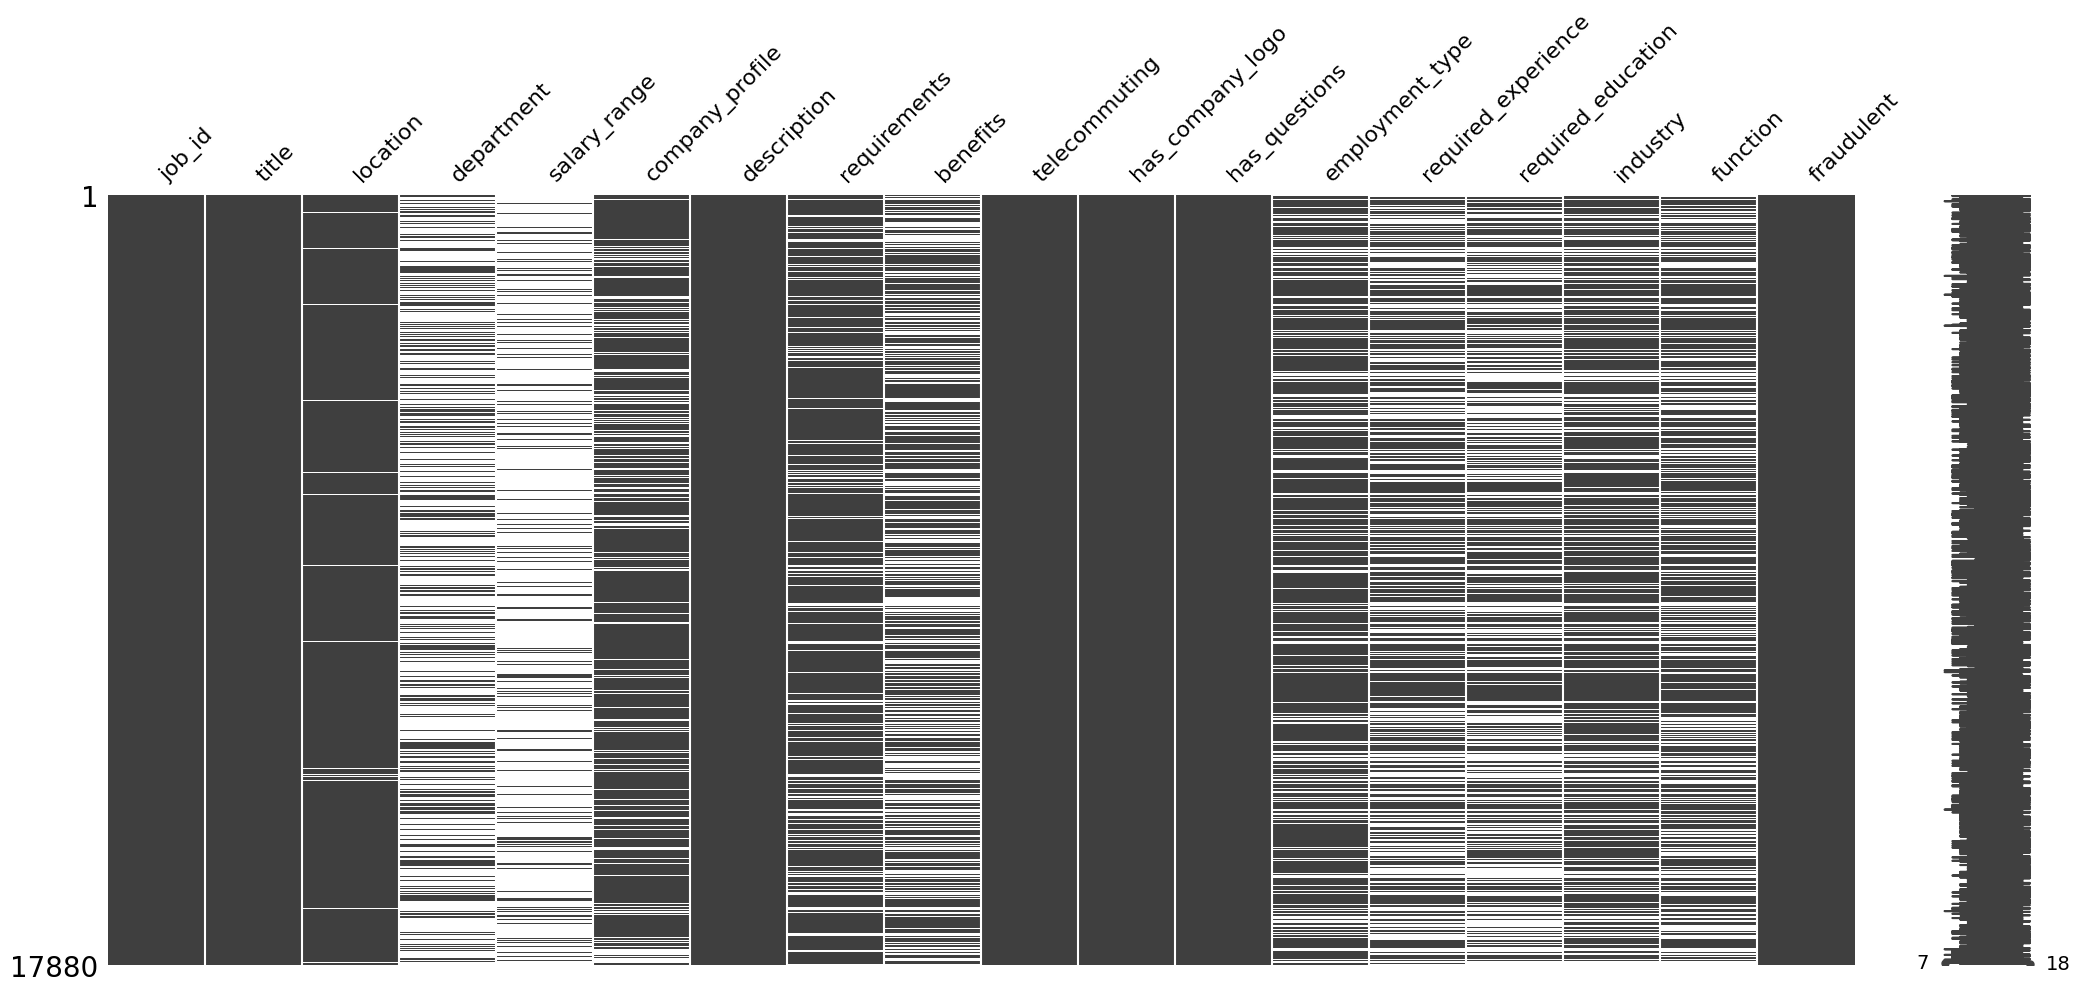

In [84]:
# The data has several numeric cols that should be thrown away and some missing values

missingno.matrix(data)

In [85]:
# Actually a lot of missing values... So, we need to throw away all the numeric features, fill the NaNs and 
# combine all the text columns into a single one

display(data.describe())
data.fillna(' ', inplace=True)

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0
17878,17879,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [87]:
old_columns = data.columns.to_list()
print(old_columns)

data["text"] = data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


In [88]:
old_columns = old_columns[:-1]
old_columns

['job_id',
 'title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [89]:
for col in old_columns:
    del data[col]

data

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,"Payroll Accountant US, PA, Philadelphia WebLin..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Studio..."


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

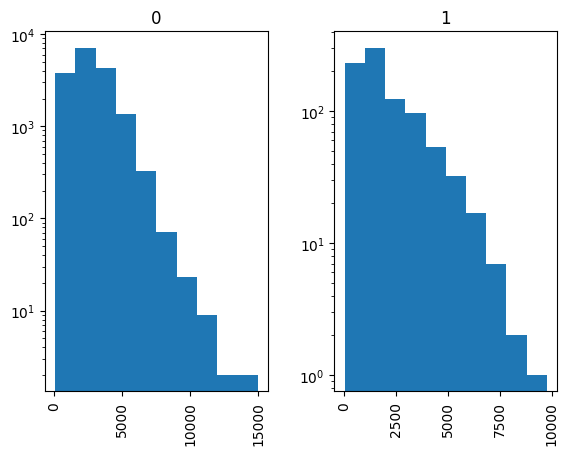

In [9]:
# now we can try to find some dependecies on the 'text'
# the first one is how does the target depend on the number of characters?
data_tmp = pd.DataFrame()
data_tmp["char_count"] = data["text"].str.len()
data_tmp["fraudulent"] = data["fraudulent"]
data_tmp.hist(column='char_count', by='fraudulent', log=True)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

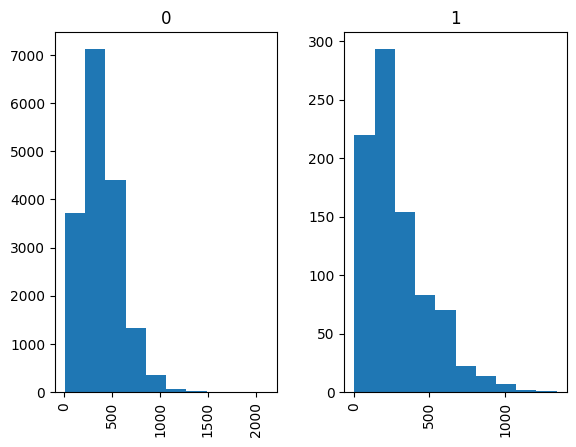

In [10]:
# the distributions are quite close, but have differnet peaks and spread

# how does the target depend on the number of words?

data_tmp = pd.DataFrame()
data_tmp["number_of_words_appearing"] = data["text"].str.split().map(lambda x: len(x))
data_tmp["fraudulent"] = data["fraudulent"]
data_tmp.hist(column='number_of_words_appearing', by='fraudulent')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

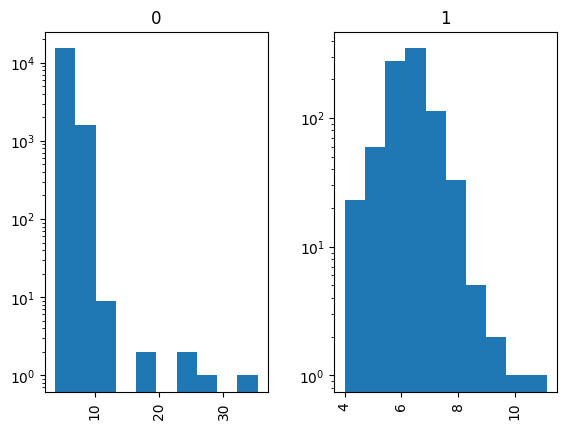

In [11]:
# the same can be observed for this point, distributions are really close

# how does the target depend on the average word length?

data_tmp = pd.DataFrame()
data_tmp["avg_word_len"] = data["text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_tmp["fraudulent"] = data["fraudulent"]
data_tmp.hist(column='avg_word_len', by='fraudulent', log = True)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

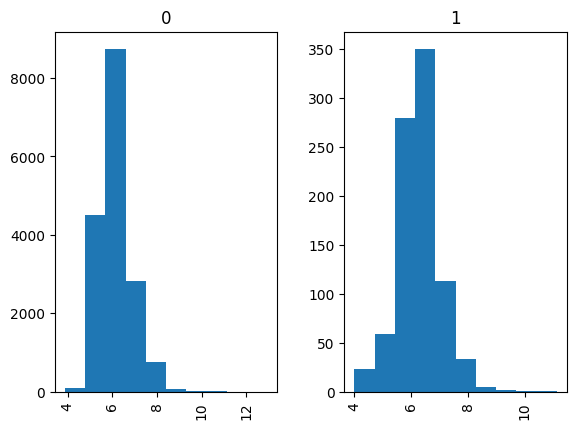

In [12]:
# redraw with no tail elements

data_tmp2 = data_tmp.drop(data_tmp[data_tmp["avg_word_len"] > 15].index)
data_tmp2.hist(column='avg_word_len', by='fraudulent')

In [13]:
# The fake jobs distribution has a higher peak 7 and wider spread, but they are still quite close

In [90]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toront..."
17876,0,"Payroll Accountant US, PA, Philadelphia WebLin..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Studios ..."


In [91]:
# punctuations remove showed 1-2% better avg accuracy

In [92]:
data['text'] = data['text'].str.lower()
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
    
data['text'] = data['text'].apply(remove_punctuations)
data

,fraudulent,text
0,0,marketing intern us ny new york were food52 we...
1,0,customer service cloud video production nz a...
2,0,commissioning machinery assistant cma us ia we...
3,0,account executive washington dc us dc washing...
4,0,bill review manager us fl fort worth spotsourc...
...,...,...
17875,0,account director distribution ca on toronto v...
17876,0,payroll accountant us pa philadelphia weblinc ...
17877,0,project cost control staff engineer cost cont...
17878,0,graphic designer ng la lagos nemsia studios lo...


In [93]:
# lemmatization showed 5% better avg accuracy

In [94]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text.split()]

data['text'] = data['text'].apply(lemmatize_text)

In [95]:
data['text'] = [' '.join(map(str, l)) for l in data['text']]
data

,fraudulent,text
0,0,marketing intern u ny new york were food52 wev...
1,0,customer service cloud video production nz auc...
2,0,commissioning machinery assistant cma u ia wev...
3,0,account executive washington dc u dc washingto...
4,0,bill review manager u fl fort worth spotsource...
...,...,...
17875,0,account director distribution ca on toronto ve...
17876,0,payroll accountant u pa philadelphia weblinc e...
17877,0,project cost control staff engineer cost contr...
17878,0,graphic designer ng la lagos nemsia studio loo...


In [111]:
# then drop symbols that are not english letters or numbers

drop_items = [item for item in set(list(data["text"].to_string())) if ord(item) >= 163]
def remove_redundant_symbols(text):
    for item in drop_items:
        text = text.replace(item, '')
    return text
    
data['text'] = data['text'].apply(remove_redundant_symbols)

In [112]:
data

,fraudulent,text
0,0,marketing intern u ny new york were food52 wev...
1,0,customer service cloud video production nz auc...
2,0,commissioning machinery assistant cma u ia wev...
3,0,account executive washington dc u dc washingto...
4,0,bill review manager u fl fort worth spotsource...
...,...,...
17875,0,account director distribution ca on toronto ve...
17876,0,payroll accountant u pa philadelphia weblinc e...
17877,0,project cost control staff engineer cost contr...
17878,0,graphic designer ng la lagos nemsia studio loo...


In [113]:
set(list(data["text"].to_string()))

{'\n',
 ' ',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

### Word embeddings

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """

    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            vector_size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, epochs=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

vectorizer = GensimWord2VecVectorizer(size=128)
vectorizer.fit(X_train.apply(lambda x: x.split(' ')))

X_train_vec = vectorizer.transform(X_train.apply(lambda x: x.split(' ')))
X_test_vec = vectorizer.transform(X_test.apply(lambda x: x.split(' ')))

##### Regression and Random Forest with prediction based method

In [82]:
clf = LogisticRegression()

from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('classifier', clf)])

# fitting our model.
pipe.fit(X_train_vec,y_train)

Pipeline(steps=[('classifier', LogisticRegression())])

In [83]:
# Predicting with a test dataset
predicted = pipe.predict(X_test_vec)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.9610365398956003


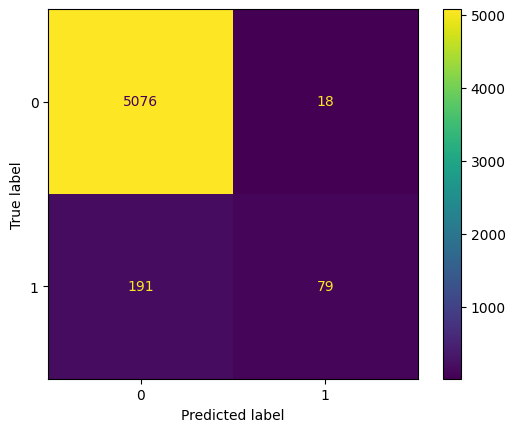

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [24]:
clf = RandomForestClassifier()

from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('classifier', clf)])

# fitting our model.
pipe.fit(X_train_vec,y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [25]:
# Predicting with a test dataset
predicted = pipe.predict(X_test_vec)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.9664429530201343


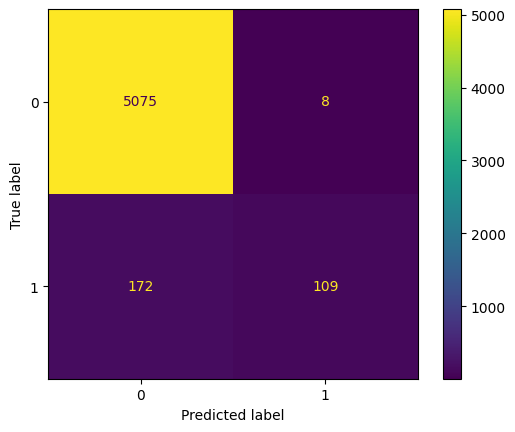

In [26]:
cm = confusion_matrix(y_test, predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

##### Regression and Random Forest with count based method

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vector = CountVectorizer(ngram_range=(1,3))

In [183]:
clf = LogisticRegression()

from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('classifier', LogisticRegression())])

In [184]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.9867636092468307


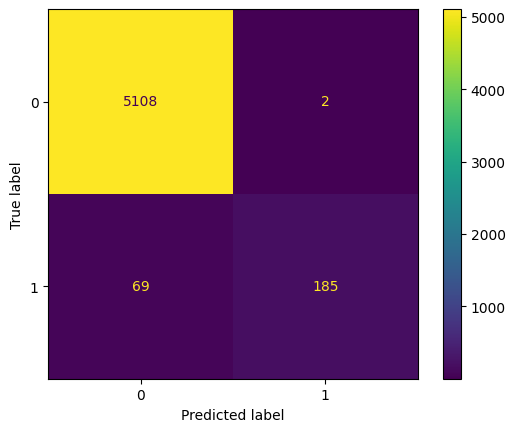

In [185]:
cm = confusion_matrix(y_test, predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [170]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('classifier', RandomForestClassifier())])

In [171]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.9819164802386279


In [191]:
# 
# ML models based on word2vec data are really weaker at finding fake jobs
# CountBased methods + Regression pipe shows 72% accuracy for the fake jobs that is much better
# The next step is NN approach using BERT tiny
#

In [17]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [41]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup


class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=2, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0
        i = -1
        for data in self.train_loader:
            i += 1
            if (i % 10 == 0):
                print(f"{i}/{len(self.train_loader)}", end="\r")
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.6*len(data)), int(.8*len(data))])

In [44]:
X_test, y_test = test["text"], test["fraudulent"]
X_eval, y_eval = validate["text"], validate["fraudulent"]
X_train, y_train = train["text"], train["fraudulent"]

In [45]:
classifier = BertClassifier(
        model_path='prajjwal1/bert-tiny', # bert-base-uncased
        tokenizer_path='prajjwal1/bert-tiny',
        n_classes=2,
        epochs=2,
        model_save_path='bert.pt'
)
   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_eval),
        y_valid=list(y_eval)
    )

In [47]:
classifier.train()

Epoch 1/2
Train loss 0.21465713119757815 accuracy 0.9529269202087994
Val loss 0.1566610660916572 accuracy 0.9661633109619687
----------
Epoch 2/2
Train loss 0.13098424626735686 accuracy 0.9719425801640567
Val loss 0.12646940982974395 accuracy 0.9737136465324385
----------


In [48]:
texts = list(X_test)

predicted = [classifier.predict(t) for t in texts]

Accuracy: 0.9695190156599552


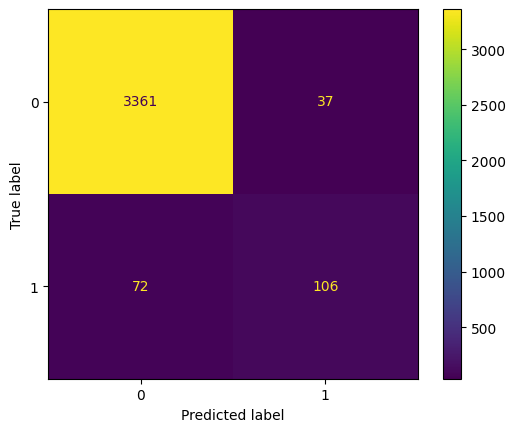

In [52]:
# Model Accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
print("Accuracy:", accuracy_score(y_test, predicted))

cm = confusion_matrix(y_test, predicted, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
# Two epoches of finetuning showed quite good accuracy that grows over training. I could train it more but it is really slow

### Additional research

Increasing vector size to 512 to keep more information in vector

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.2)

vectorizer = GensimWord2VecVectorizer(size=512)
vectorizer.fit(X_train.apply(lambda x: x.split(' ')))

X_train_vec = vectorizer.transform(X_train.apply(lambda x: x.split(' ')))
X_test_vec = vectorizer.transform(X_test.apply(lambda x: x.split(' ')))

In [115]:
sum(y_train) / len(y_train), sum(y_test) / len(y_test)

(0.04788870246085011, 0.05061521252796421)

In [116]:
clf = LogisticRegression()

from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('classifier', clf)])

# fitting our model.
pipe.fit(X_train_vec,y_train) 

C:\Users\pwx1010094\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('classifier', LogisticRegression())])

Accuracy: 0.9600111856823266
Average Accuracy: 0.6363542421012376


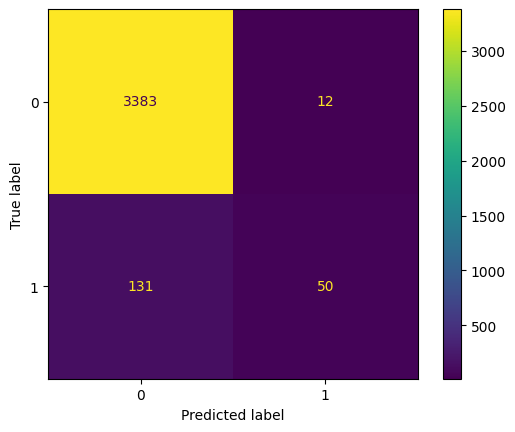

In [121]:
# Predicting with a test dataset
predicted = pipe.predict(X_test_vec)

# Model Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted, labels=clf.classes_)

print("Accuracy:", accuracy_score(y_test, predicted))
print("Average Accuracy:", sum(cm.diagonal()/cm.sum(axis=1))/2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
# Vector size increase showed some accuracy gain in some experiments but it is quite unstable

The next one is amplifying the difference: the words that are used a lot in both fake/real texts are removed

In [123]:
data_real = data[data.fraudulent == 0]
data_fake = data[data.fraudulent == 1]

In [124]:
data_fake

,fraudulent,text
98,1,ice technician u stocton ca staffing amp recru...
144,1,forward cap the group raised fund purchase hom...
173,1,technician instrument control u edison interna...
180,1,sale executive pk sd karachi sale executive sa...
215,1,ice technician mt poso u ca bakersfield ca mt ...
...,...,...
17827,1,student position parttime fulltime u ca los an...
17828,1,sale associate au nsw sydney learn to earn an ...
17829,1,android developer pl mz warsaw infullmobile sp...
17830,1,payroll clerk u ny new york job descriptionwe ...


In [148]:
from collections import Counter

counter_real = Counter(data_real["text"].iloc[0].split())
for i in range(1, len(data_real)):
    print(f"{i}/{len(data_real)}", end="\r")
    counter_real += Counter(data_real["text"].iloc[i].split())

counter_real

Counter({'team': 34979,
         'work': 34499,
         'experience': 33816,
         'we': 30173,
         'service': 27020,
         'company': 26080,
         'customer': 25042,
         'business': 22807,
         'u': 21624,
         'product': 18510,
         'client': 18202,
         'new': 18134,
         'year': 16289,
         'skill': 15923,
         'sale': 15539,
         'the': 15481,
         'development': 15269,
         'management': 15156,
         'working': 14546,
         'amp': 14193,
         'project': 13386,
         'technology': 12891,
         'job': 12843,
         'opportunity': 12477,
         'people': 12217,
         'design': 12187,
         'solution': 12031,
         'marketing': 11968,
         'looking': 11755,
         'communication': 11612,
         'you': 11209,
         'time': 11195,
         'help': 10422,
         'position': 10213,
         'our': 10213,
         'ability': 10118,
         'software': 10083,
         'support': 9924,
   

In [149]:
counter_fake = Counter(data_fake["text"].iloc[0].split())
for i in range(1, len(data_fake)):
    counter_fake += Counter(data_fake["text"].iloc[i].split())

counter_fake

Counter({'work': 1628,
         'experience': 1427,
         'service': 1225,
         'skill': 1107,
         'we': 1055,
         'customer': 1007,
         'amp': 982,
         'u': 979,
         'product': 896,
         'team': 873,
         'company': 870,
         'position': 838,
         'project': 797,
         'business': 744,
         'management': 694,
         'system': 686,
         'time': 653,
         'year': 647,
         'engineering': 595,
         'data': 592,
         'ability': 580,
         'new': 573,
         'solution': 542,
         'process': 518,
         'candidate': 517,
         'communication': 504,
         'support': 503,
         'environment': 503,
         'industry': 480,
         'opportunity': 470,
         'technology': 463,
         'job': 462,
         'employee': 461,
         'development': 460,
         'looking': 457,
         'working': 455,
         'client': 454,
         'within': 451,
         'manager': 449,
         'knowledge': 4

In [150]:
to_drop_words = ["work", "experience", "we", "service", "team", "company", "customer", "u", "product"]

In [153]:
def remove_drop(text):
    for item in to_drop_words:
        text = text.replace(item, '')
    return text
    
data['text'] = data['text'].apply(remove_drop)

In [154]:
data

,fraudulent,text
0,0,marketing intern ny new york re food52 ve cre...
1,0,clod video prodction nz ackland 90 second wo...
2,0,commissioning machinery assistant cma ia ver ...
3,0,accont exective washington dc dc washington o...
4,0,bill review manager fl fort worth spotsorce s...
...,...,...
17875,0,accont director distribtion ca on toronto vend...
17876,0,payroll accontant pa philadelphia blinc ecomm...
17877,0,project cost control staff engineer cost contr...
17878,0,graphic designer ng la lagos nemsia stdio look...


In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.2)

vectorizer = GensimWord2VecVectorizer(size=512)
vectorizer.fit(X_train.apply(lambda x: x.split(' ')))

X_train_vec = vectorizer.transform(X_train.apply(lambda x: x.split(' ')))
X_test_vec = vectorizer.transform(X_test.apply(lambda x: x.split(' ')))

Accuracy: 0.4974832214765101
Average Accuracy: 0.49733720286624683


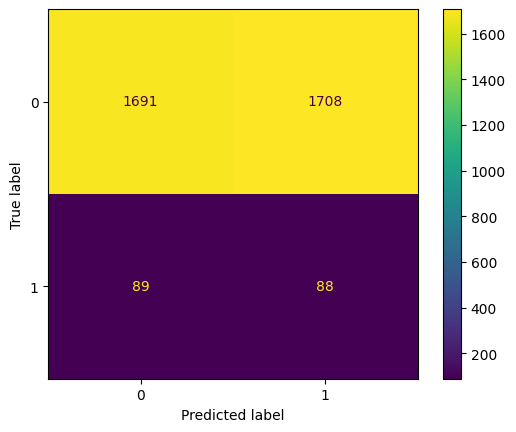

In [156]:
# Predicting with a test dataset
predicted = pipe.predict(X_test_vec)

# Model Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted, labels=clf.classes_)

print("Accuracy:", accuracy_score(y_test, predicted))
print("Average Accuracy:", sum(cm.diagonal()/cm.sum(axis=1))/2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [159]:
# The word2vec based classifier has become a random classifier now which is unclear for me, however...

Logistic Regression Accuracy: 0.9890939597315436


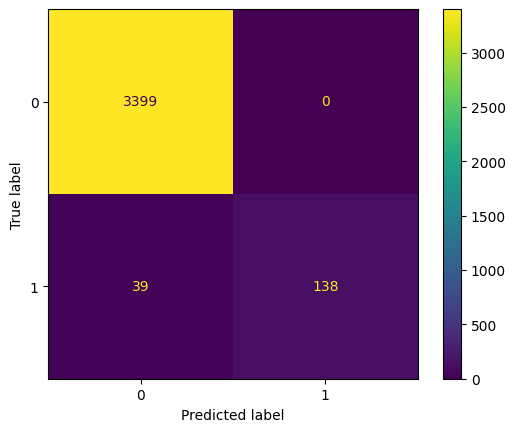

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vector = CountVectorizer(ngram_range=(1,3))

clf = LogisticRegression()

from sklearn.pipeline import Pipeline

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))

cm = confusion_matrix(y_test, predicted, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [158]:
print("Average Accuracy:", sum(cm.diagonal()/cm.sum(axis=1))/2)

Average Accuracy: 0.8898305084745763


In [ ]:
# However, the CountVectorizer pipeline showed Accuracy increase for fake jobs by 5% and average accuracy almost reached 90%
# that is really cool